
# Inaugural Project


Cecilie Gøtterup-Hansen and Helene Thomsen - Exercise class 3

First we import the packages being used

In [32]:
#Import 
from types import SimpleNamespace

import numpy as np
from scipy import optimize

import pandas as pd 
import matplotlib.pyplot as plt

The following code is presented for the assignment. We have added the constraint for the home production. The constraint can give 3 output, depending in the value of sigma, =0, =1 or =(0,1).

In [80]:
class HouseholdSpecializationModelClass:

    def __init__(self):
        """ setup model """

        # a. create namespaces
        par = self.par = SimpleNamespace()
        sol = self.sol = SimpleNamespace()

        # b. preferences
        par.rho = 2.0
        par.nu = 0.001
        par.epsilon = 1.0
        par.omega = 0.5 

        # c. household production
        par.alpha = 0.5
        par.sigma = 1.0

        # d. wages
        par.wM = 1.0
        par.wF = 1.0
        par.wF_vec = np.linspace(0.8,1.2,5)

        # e. targets
        par.beta0_target = 0.4
        par.beta1_target = -0.1

        # f. solution
        sol.LM_vec = np.zeros(par.wF_vec.size)
        sol.HM_vec = np.zeros(par.wF_vec.size)
        sol.LF_vec = np.zeros(par.wF_vec.size)
        sol.HF_vec = np.zeros(par.wF_vec.size)

        sol.beta0 = np.nan
        sol.beta1 = np.nan

    def calc_utility(self,LM,HM,LF,HF):
        """ calculate utility """

        par = self.par
        sol = self.sol

        # a. consumption of market goods
        C = par.wM*LM + par.wF*LF

        # b. home production
        if par.sigma == 0:
            H = np.fmin(HM, HF)
        elif par.sigma == 1:
            H = HM**(1-par.alpha)*HF**par.alpha
        else:
            H = ((1-par.alpha)*HM**((par.sigma-1)/(par.sigma)) + par.alpha*HF**((par.sigma-1)/(par.sigma)))**(par.sigma/(par.sigma-1))

        # c. total consumption utility
        Q = C**par.omega*H**(1-par.omega)
        utility = np.fmax(Q,1e-8)**(1-par.rho)/(1-par.rho)

        # d. disutility of work
        epsilon_ = 1+1/par.epsilon
        TM = LM+HM
        TF = LF+HF
        disutility = par.nu*(TM**epsilon_/epsilon_+TF**epsilon_/epsilon_)
        
        return utility - disutility

    def solve_discrete(self,do_print=False):
        """ solve model discretely """
        
        par = self.par
        sol = self.sol
        opt = SimpleNamespace()
        
        # a. all possible choices
        x = np.linspace(0,24,49)
        LM,HM,LF,HF = np.meshgrid(x,x,x,x) # all combinations
    
        LM = LM.ravel() # vector
        HM = HM.ravel()
        LF = LF.ravel()
        HF = HF.ravel()

        # b. calculate utility
        u = self.calc_utility(LM,HM,LF,HF)
    
        # c. set to minus infinity if constraint is broken
        I = (LM+HM > 24) | (LF+HF > 24) # | is "or"
        u[I] = -np.inf
    
        # d. find maximizing argument
        j = np.argmax(u)
        
        opt.LM = LM[j]
        opt.HM = HM[j]
        opt.LF = LF[j]
        opt.HF = HF[j]          

        # e. print
        if do_print:
            for k,v in opt.__dict__.items():
                print(f'{k} = {v:6.4f}')

        return opt

    def solve(self,do_print=False):
        """ solve model continously """
        
        opt = SimpleNamespace()

        # define objective function to maximize
        def objective(x):
            LM, HM, LF, HF = x
            return -self.calc_utility(LM, HM, LF, HF)

        # define constraints and bounds
        def constraints(x):
            LM, HM, LF, HF = x
            return [24 - LM - HM, 24 - LF - HF]
        
        constraints = ({'type':'ineq', 'fun': constraints})
        bounds = ((0,24),(0,24),(0,24),(0,24))

        # initial guess
        initial_guess = [6, 6, 6, 6]

        # call solver
        solution = optimize.minimize(
            objective, initial_guess, 
            method='Nelder-Mead', 
            bounds=bounds, 
            constraints=constraints
            )
        
        opt.LM, opt.HM, opt.LF, opt.HF = solution.x

        return opt
   

    def solve_wF_vec(self,discrete=False):
        """ solve model for vector of female wages """

        par = self.par
        sol = self.sol

        # fill out solution vectors for HF and HM
        for i, wF in enumerate(par.wF_vec):
            par.wF = wF
            optimum = self.solve()
            sol.HF_vec[i] = optimum.HF
            sol.HM_vec[i] = optimum.HM
            sol.LF_vec[i] = optimum.LF
            sol.LM_vec[i] = optimum.LM
        
        return sol.HF_vec, sol.HM_vec, sol.LF_vec, sol.LM_vec


    def run_regression(self):
        """ run regression """

        par = self.par
        sol = self.sol
        
        self.solve_wF_vec()

        x = np.log(par.wF_vec)
        y = np.log(sol.HF_vec/sol.HM_vec)
        A = np.vstack([np.ones(x.size),x]).T

        sol.beta0,sol.beta1 = np.linalg.lstsq(A,y,rcond=None)[0]

        return sol.beta0,sol.beta1
    
    def estimate(self,alpha=None,sigma=None):
        """ estimate alpha and sigma """
        
        par = self.par
        sol = self.sol

        # define objective function to minimize
        def objective(x):
            alpha, sigma = x
            par.alpha = alpha
            par.sigma = sigma
            self.solve_wF_vec()
            self.run_regression()
            return (par.beta0_target - sol.beta0)**2+(par.beta1_target - sol.beta1)**2
        
        # initial guess
        initial_guess = [0.5, 1.0]

        # call solver
        solution = optimize.minimize(objective, initial_guess, method='Nelder-Mead')

        alpha_min, sigma_min = solution.x

        return alpha_min, sigma_min 
    

### **Question 1**


First we call the class form the code above. We make a for loop for alpha and sigma in the 9 combinations to find the optimal values of HF and HF at each combination. Using the definition of the function solve_discrete.
Based on these values we find the ratio of the home production for the female and the male. 

In [43]:
model1 = HouseholdSpecializationModelClass()

for alpha in np.linspace(0.25, 0.75, 3):
    model1.par.alpha = alpha
    for sigma in np.linspace(0.5, 1.5, 3):
        model1.par.sigma = sigma
        # call solve function and compute HF-HM-ratio
        opt = model1.solve_discrete()
        optHF = opt.HF
        optHM = opt.HM
        ratio = opt.HF/opt.HM
        print(f'where alpha = {alpha:.2f}, sigma = {sigma:.2f} -> HF/HM ratio = {ratio:.2f}')
        


C:\Users\cecil\AppData\Local\Temp\ipykernel_12996\963634548.py:53: RuntimeWarning: divide by zero encountered in reciprocal
  H = ((1-par.alpha)*HM**((par.sigma-1)/(par.sigma)) + par.alpha*HF**((par.sigma-1)/(par.sigma)))**(par.sigma/(par.sigma-1))


where alpha = 0.25, sigma = 0.50 -> HF/HM ratio = 0.55
where alpha = 0.25, sigma = 1.00 -> HF/HM ratio = 0.31
where alpha = 0.25, sigma = 1.50 -> HF/HM ratio = 0.21
where alpha = 0.50, sigma = 0.50 -> HF/HM ratio = 1.00
where alpha = 0.50, sigma = 1.00 -> HF/HM ratio = 1.00
where alpha = 0.50, sigma = 1.50 -> HF/HM ratio = 1.00
where alpha = 0.75, sigma = 0.50 -> HF/HM ratio = 1.83
where alpha = 0.75, sigma = 1.00 -> HF/HM ratio = 3.25
where alpha = 0.75, sigma = 1.50 -> HF/HM ratio = 4.67


We notice that a RuntimeWarning occurs warning us about the possibility of dividing by zero in our definition of H. This we have handled this risk of dividing by zero, by defining H otherwise when this is possible (when sigma takes on values of 0 or 1).

alpha represents how productive the woman is in household production. 

For alpha = 0.5, the male and the female are equally productive in the household production. They will therefore work the same amount of hours at home. For alpha = 0.5 (meaning that the female and the male are equally productive), the value of sigma (the elasticity of substitution) does not affect the choices of hours spend at home production.

For alpha > 0.5, the female is more productive than the male in the household production. For wF = wM = 1, the female will work more hours at home relative to the male.

For alpha < 0.5, the female is less productive than the male in the household production. For wF = wM = 1, the male will work more hours at home relative to the female. 

### **Question 2**

In order to plot the log ratios of the female male production and the log wage ratio, we call the model and fore looping the wage vecor for the female. We define the need log ratios of the optimal home production weight and the log wage ratio. We print the numbers.

In [74]:
model2 = HouseholdSpecializationModelClass()

log_Hratio = []
log_wratio = []

for wF in model2.par.wF_vec:
    model2.par.wF = wF
    optimum = model2.solve_discrete()
    log_HFM = np.log(optimum.HF/optimum.HM)
    log_Hratio = np.append(log_Hratio, log_HFM)
    log_wF = np.log(wF/model2.par.wM)
    log_wratio = np.append(log_wratio, log_wF)

[ 0.22314355  0.          0.         -0.11778304 -0.22314355]
[-0.22314355 -0.10536052  0.          0.09531018  0.18232156]


Plotting the results with our specifications we can plot out the above results.

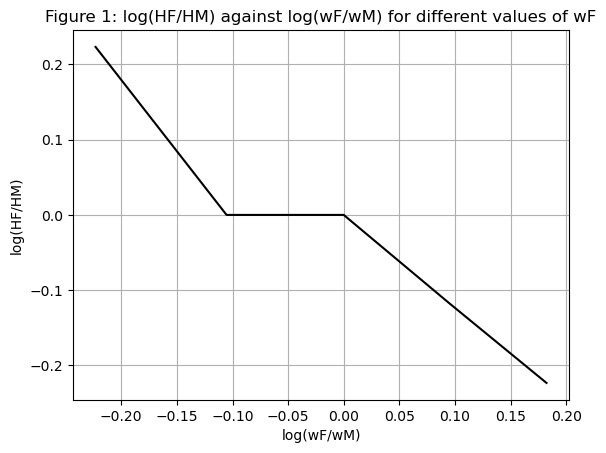

In [75]:
# create figure
fig = plt.figure()
# create plot
ax = fig.add_subplot(1, 1, 1)
ax.plot(log_wratio, log_Hratio, color='black')
# alterations to figure
ax.grid()
ax.set_xlabel("log(wF/wM)")
ax.set_ylabel("log(HF/HM)")
ax.set_title("Figure 1: log(HF/HM) against log(wF/wM) for different values of wF")
plt.show()

We see the decline in the log home production for an increase in the log in the wage ratio. This means that for an increase in the female wage, the amount of home production declines for the female. When the wage for the female and male are equal, the home production is equal for the female and male. 

### **Question 3**

We now do the same as above, but for a continuous choice set of hours worked. The continuous choice set gives us an infinite amount of possible combinations of hours worked, why the results of the maximization problem using a solver is going to be more precise.

In [76]:
model3 = HouseholdSpecializationModelClass()

# define empty vectors of log(HF/HM) and log(wF/wM)
log_Hratio = []
log_wratio = []

# calculate values of log(HF/HM) and log(wF/wM) and append values to their respective vectors
for wF in model3.par.wF_vec:
    model3.par.wF = wF
    optimum = model3.solve()
    log_HFM = np.log(optimum.HF/optimum.HM)
    log_Hratio = np.append(log_Hratio, log_HFM)
    log_wF = np.log(wF/model3.par.wM)
    log_wratio = np.append(log_wratio, log_wF)
    util = model3.calc_utility(optimum.LM, optimum.HM, optimum.LF, optimum.HF)
    print(f' For Wf = {model3.par.wF:.2f}: LM = {optimum.LM:.2f}, HM = {optimum.HM:.2f}, LF = {optimum.LF:.2f}, HF = {optimum.HF:.2f}, utility = {util:.5f} ') #Printing optimal values




 For Wf = 0.80: LM = 5.89, HM = 4.09, LF = 2.87, HF = 5.12, utility = -0.24511 
 For Wf = 0.90: LM = 5.17, HM = 4.27, LF = 3.75, HF = 4.75, utility = -0.24188 
 For Wf = 1.00: LM = 4.45, HM = 4.45, LF = 4.45, HF = 4.45, utility = -0.23811 
 For Wf = 1.10: LM = 3.76, HM = 4.64, LF = 5.02, HF = 4.22, utility = -0.23400 
 For Wf = 1.20: LM = 3.09, HM = 4.83, LF = 5.48, HF = 4.03, utility = -0.22971 


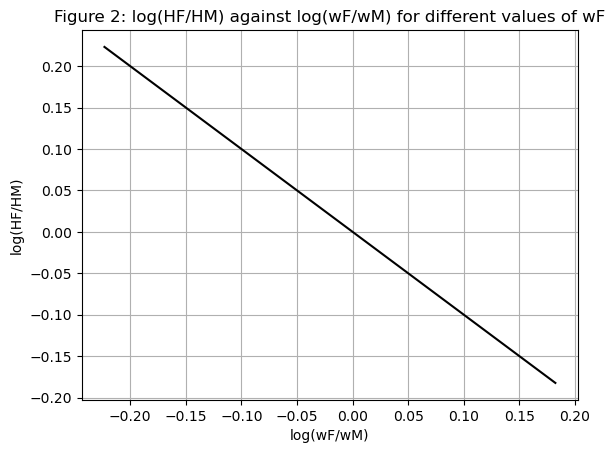

In [77]:
# create figure
fig = plt.figure()
# create plot
ax = fig.add_subplot(1, 1, 1)
ax.plot(log_wratio, log_Hratio, color='black')
# alterations to figure
ax.grid()
ax.set_xlabel("log(wF/wM)")
ax.set_ylabel("log(HF/HM)")
ax.set_title("Figure 2: log(HF/HM) against log(wF/wM) for different values of wF")
plt.show()

As expected our illustration in question 3 has a smoother curve. This is due to the ifinite combinations of hours in home production, insted of the 48 steps.  

### **Question 4**

Using the function estimate(), we estimate the values of alpha and sigma which minimzes the squared distance between beta0 and beta0_target and the squared difference between beta1 and beta1_target.

C:\Users\cecil\AppData\Local\Temp\ipykernel_12996\377614052.py:166: RuntimeWarning: divide by zero encountered in divide
  y = np.log(sol.HF_vec/sol.HM_vec)
C:\Users\cecil\AppData\Local\Temp\ipykernel_12996\377614052.py:53: RuntimeWarning: invalid value encountered in double_scalars
  H = ((1-par.alpha)*HM**((par.sigma-1)/(par.sigma)) + par.alpha*HF**((par.sigma-1)/(par.sigma)))**(par.sigma/(par.sigma-1))
C:\Users\cecil\AppData\Local\Temp\ipykernel_12996\377614052.py:53: RuntimeWarning: divide by zero encountered in double_scalars
  H = ((1-par.alpha)*HM**((par.sigma-1)/(par.sigma)) + par.alpha*HF**((par.sigma-1)/(par.sigma)))**(par.sigma/(par.sigma-1))


The minimizing values of (alpha, sigma) = (0.9820286655282875, 0.09997820455973572)


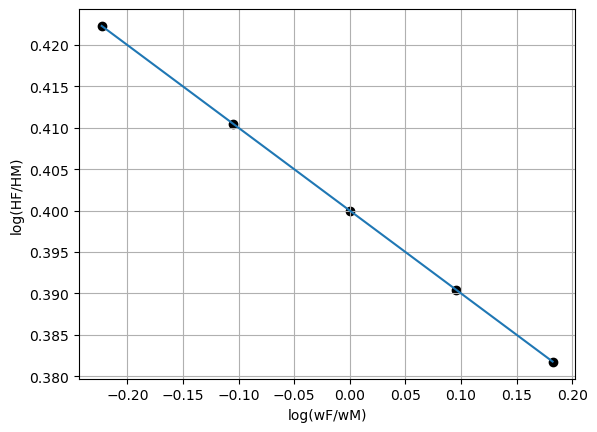

In [81]:
model4 = HouseholdSpecializationModelClass()
model4.estimate()
print(f'The minimizing values of (alpha, sigma) = {model4.estimate()}')


log_Hratio = []
log_wratio =[]

for wF in model4.par.wF_vec:
    model4.par.wF = wF
    optimum = model4.solve()
    log_HFM = np.log(optimum.HF/optimum.HM)
    log_Hratio = np.append(log_Hratio, log_HFM)
    log_wF = np.log(wF/model4.par.wM)
    log_wratio = np.append(log_wratio, log_wF)



# Siminski and Yetsenga's regression line
def f(log_wratio):
    return 0.4 +(-0.1)*log_wratio


# create figure
fig = plt.figure()
# create plot
ax = fig.add_subplot(1, 1, 1)
# plot Siminski and Yetsengaøs results as line
ax.plot(log_wratio, f(log_wratio))
# plot model's results as scatter dots
ax.scatter(log_wratio, log_Hratio, color='black')

#mangler legend#
# alterations to figure
ax.grid()
ax.set_xlabel("log(wF/wM)")
ax.set_ylabel("log(HF/HM)")
ax.set_title("")
plt.show()

